In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# # Load the feature selection results
# with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
#     feature_selection_lgbm = json.load(f)

# with open('../feat_selection/select_optuna_catb.json', 'r') as f:
#     feature_selection_catb = json.load(f)

# # Extract the selected features
# numerical_cols = feature_selection_lgbm.get('numerical', [])
# categorical_cols = feature_selection_lgbm.get('categorical', [])

# # numerical_cols = list(set(feature_selection_lgbm.get('numerical', []) + feature_selection_catb.get('numerical', [])))
# # categorical_cols = list(set(feature_selection_lgbm.get('categorical', []) + feature_selection_catb.get('categorical', [])))

# # text_cols = ["LudRules",]
# text_cols = list()

# print("Numerical features:", len(numerical_cols))
# print("Categorical features:", len(categorical_cols))
# print("Text features:", len(text_cols))

In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    # numerical_cols=numerical_cols,
    # categorical_cols=categorical_cols,
    include_position_features=False,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  18


number of constant cols:  198


Numerical Columns: 588
Categorical Columns: 10


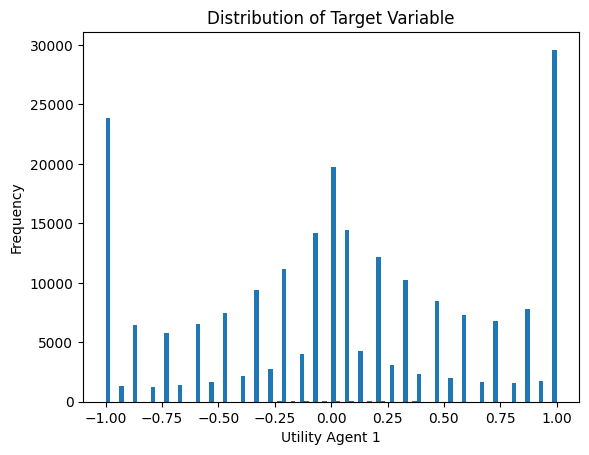

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [6]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [7]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [8]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6127167	test: 0.5486653	best: 0.5486653 (0)	total: 187ms	remaining: 9m 20s


50:	learn: 0.3829729	test: 0.4576529	best: 0.4576529 (50)	total: 6.2s	remaining: 5m 58s


100:	learn: 0.3421017	test: 0.4412584	best: 0.4412584 (100)	total: 12.5s	remaining: 5m 59s


150:	learn: 0.3210224	test: 0.4332371	best: 0.4332371 (150)	total: 18.9s	remaining: 5m 56s


200:	learn: 0.3053661	test: 0.4292646	best: 0.4292153 (199)	total: 25.3s	remaining: 5m 52s


250:	learn: 0.2944862	test: 0.4268011	best: 0.4268011 (250)	total: 31.8s	remaining: 5m 47s


300:	learn: 0.2842745	test: 0.4243537	best: 0.4243537 (300)	total: 38.1s	remaining: 5m 41s


350:	learn: 0.2760615	test: 0.4227140	best: 0.4226062 (347)	total: 44.4s	remaining: 5m 35s


400:	learn: 0.2695802	test: 0.4218192	best: 0.4218117 (398)	total: 51s	remaining: 5m 30s


450:	learn: 0.2638452	test: 0.4210091	best: 0.4209674 (447)	total: 57.5s	remaining: 5m 25s


500:	learn: 0.2587943	test: 0.4203196	best: 0.4203196 (500)	total: 1m 3s	remaining: 5m 19s


550:	learn: 0.2535544	test: 0.4196280	best: 0.4196280 (550)	total: 1m 10s	remaining: 5m 13s


600:	learn: 0.2484934	test: 0.4190202	best: 0.4190202 (600)	total: 1m 16s	remaining: 5m 7s


650:	learn: 0.2441719	test: 0.4183747	best: 0.4183696 (647)	total: 1m 23s	remaining: 5m 1s


700:	learn: 0.2404356	test: 0.4178338	best: 0.4178338 (700)	total: 1m 30s	remaining: 4m 55s


750:	learn: 0.2369524	test: 0.4174415	best: 0.4174415 (750)	total: 1m 36s	remaining: 4m 49s


800:	learn: 0.2335618	test: 0.4171442	best: 0.4171442 (800)	total: 1m 43s	remaining: 4m 43s


850:	learn: 0.2306026	test: 0.4169642	best: 0.4169379 (849)	total: 1m 49s	remaining: 4m 37s


900:	learn: 0.2277737	test: 0.4167319	best: 0.4167201 (891)	total: 1m 56s	remaining: 4m 31s


950:	learn: 0.2251039	test: 0.4166086	best: 0.4165921 (920)	total: 2m 3s	remaining: 4m 25s


1000:	learn: 0.2226763	test: 0.4162857	best: 0.4162361 (996)	total: 2m 9s	remaining: 4m 19s


1050:	learn: 0.2202339	test: 0.4160515	best: 0.4160515 (1050)	total: 2m 16s	remaining: 4m 12s


1100:	learn: 0.2175309	test: 0.4159028	best: 0.4158975 (1099)	total: 2m 22s	remaining: 4m 6s


1150:	learn: 0.2151079	test: 0.4158516	best: 0.4158290 (1122)	total: 2m 29s	remaining: 4m


1200:	learn: 0.2127460	test: 0.4158345	best: 0.4157976 (1166)	total: 2m 36s	remaining: 3m 53s


1250:	learn: 0.2106284	test: 0.4158198	best: 0.4157736 (1216)	total: 2m 43s	remaining: 3m 47s


1300:	learn: 0.2083750	test: 0.4157202	best: 0.4157026 (1299)	total: 2m 49s	remaining: 3m 41s


1350:	learn: 0.2061651	test: 0.4156128	best: 0.4155653 (1329)	total: 2m 56s	remaining: 3m 35s


1400:	learn: 0.2040733	test: 0.4155479	best: 0.4155425 (1399)	total: 3m 2s	remaining: 3m 28s


1450:	learn: 0.2023237	test: 0.4155506	best: 0.4155345 (1438)	total: 3m 9s	remaining: 3m 22s


1500:	learn: 0.2005750	test: 0.4154498	best: 0.4154153 (1490)	total: 3m 16s	remaining: 3m 15s


1550:	learn: 0.1985299	test: 0.4153872	best: 0.4153766 (1547)	total: 3m 22s	remaining: 3m 9s


1600:	learn: 0.1966404	test: 0.4154289	best: 0.4153766 (1547)	total: 3m 29s	remaining: 3m 2s


1650:	learn: 0.1945724	test: 0.4152157	best: 0.4152157 (1650)	total: 3m 35s	remaining: 2m 56s


1700:	learn: 0.1928910	test: 0.4151680	best: 0.4151596 (1696)	total: 3m 42s	remaining: 2m 49s


1750:	learn: 0.1910474	test: 0.4151927	best: 0.4151596 (1696)	total: 3m 48s	remaining: 2m 43s


1800:	learn: 0.1895170	test: 0.4151144	best: 0.4150987 (1798)	total: 3m 55s	remaining: 2m 36s


1850:	learn: 0.1879752	test: 0.4151388	best: 0.4150987 (1798)	total: 4m 1s	remaining: 2m 30s


1900:	learn: 0.1862422	test: 0.4151727	best: 0.4150987 (1798)	total: 4m 8s	remaining: 2m 23s


1950:	learn: 0.1848234	test: 0.4150798	best: 0.4150796 (1948)	total: 4m 15s	remaining: 2m 17s


2000:	learn: 0.1833612	test: 0.4150706	best: 0.4150271 (1970)	total: 4m 22s	remaining: 2m 10s


2050:	learn: 0.1818478	test: 0.4151385	best: 0.4150271 (1970)	total: 4m 28s	remaining: 2m 4s


2100:	learn: 0.1805763	test: 0.4150876	best: 0.4150271 (1970)	total: 4m 35s	remaining: 1m 57s


2150:	learn: 0.1791314	test: 0.4151175	best: 0.4150271 (1970)	total: 4m 41s	remaining: 1m 51s


2200:	learn: 0.1778535	test: 0.4151352	best: 0.4150271 (1970)	total: 4m 48s	remaining: 1m 44s


2250:	learn: 0.1762946	test: 0.4151436	best: 0.4150271 (1970)	total: 4m 55s	remaining: 1m 38s


2300:	learn: 0.1749535	test: 0.4150683	best: 0.4150271 (1970)	total: 5m 1s	remaining: 1m 31s


2350:	learn: 0.1737268	test: 0.4151293	best: 0.4150271 (1970)	total: 5m 8s	remaining: 1m 25s


2400:	learn: 0.1722923	test: 0.4151836	best: 0.4150271 (1970)	total: 5m 15s	remaining: 1m 18s


2450:	learn: 0.1709548	test: 0.4151757	best: 0.4150271 (1970)	total: 5m 21s	remaining: 1m 12s


2500:	learn: 0.1695724	test: 0.4151108	best: 0.4150271 (1970)	total: 5m 28s	remaining: 1m 5s


2550:	learn: 0.1684513	test: 0.4151261	best: 0.4150271 (1970)	total: 5m 34s	remaining: 59s


2600:	learn: 0.1673248	test: 0.4151192	best: 0.4150271 (1970)	total: 5m 41s	remaining: 52.4s


2650:	learn: 0.1659322	test: 0.4151099	best: 0.4150271 (1970)	total: 5m 48s	remaining: 45.8s


2700:	learn: 0.1646327	test: 0.4151251	best: 0.4150271 (1970)	total: 5m 54s	remaining: 39.3s


2750:	learn: 0.1631965	test: 0.4151877	best: 0.4150271 (1970)	total: 6m 1s	remaining: 32.7s


2800:	learn: 0.1620626	test: 0.4151739	best: 0.4150271 (1970)	total: 6m 7s	remaining: 26.1s


2850:	learn: 0.1609857	test: 0.4151869	best: 0.4150271 (1970)	total: 6m 14s	remaining: 19.6s


2900:	learn: 0.1597359	test: 0.4151604	best: 0.4150271 (1970)	total: 6m 21s	remaining: 13s


2950:	learn: 0.1585846	test: 0.4152289	best: 0.4150271 (1970)	total: 6m 27s	remaining: 6.44s


2999:	learn: 0.1574586	test: 0.4152164	best: 0.4150271 (1970)	total: 6m 34s	remaining: 0us

bestTest = 0.4150270989
bestIteration = 1970

Shrink model to first 1971 iterations.


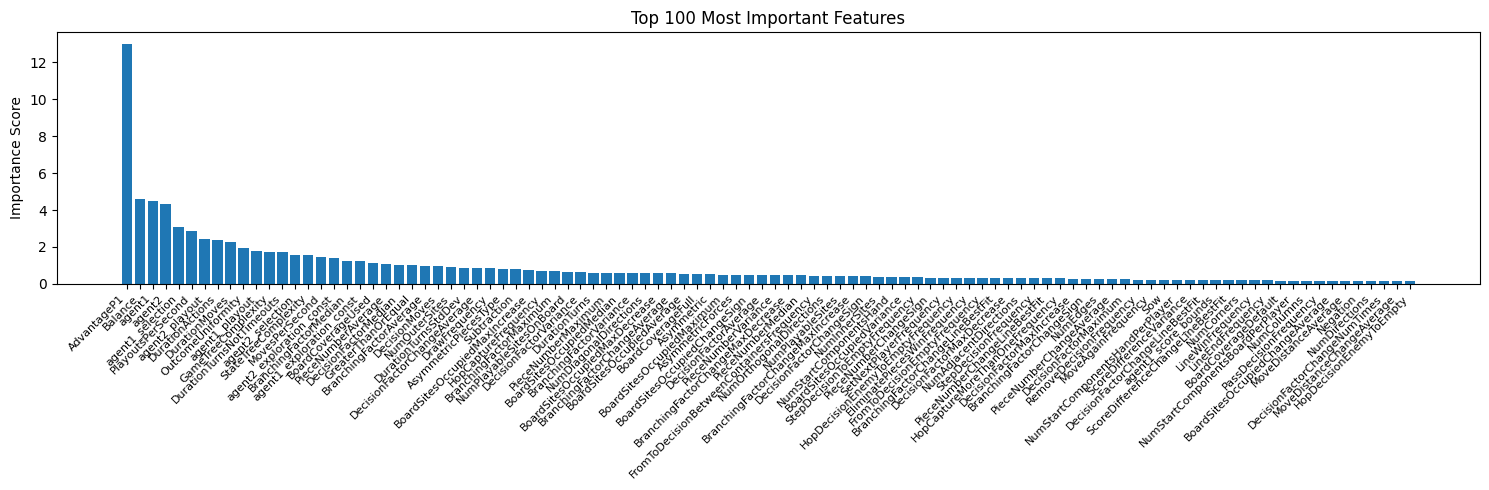

Fold 1 - RMSE: 0.41473341825229054
Fold 2


0:	learn: 0.6057644	test: 0.5785526	best: 0.5785526 (0)	total: 122ms	remaining: 6m 6s


50:	learn: 0.3919989	test: 0.4761254	best: 0.4761254 (50)	total: 6.42s	remaining: 6m 11s


100:	learn: 0.3520228	test: 0.4605613	best: 0.4605613 (100)	total: 13.1s	remaining: 6m 15s


150:	learn: 0.3288230	test: 0.4537394	best: 0.4537394 (150)	total: 19.4s	remaining: 6m 6s


200:	learn: 0.3136009	test: 0.4507435	best: 0.4507356 (199)	total: 26s	remaining: 6m 1s


250:	learn: 0.3019942	test: 0.4472944	best: 0.4472944 (250)	total: 32.5s	remaining: 5m 56s


300:	learn: 0.2928075	test: 0.4460207	best: 0.4460096 (294)	total: 39.2s	remaining: 5m 51s


350:	learn: 0.2850960	test: 0.4448987	best: 0.4448987 (350)	total: 45.8s	remaining: 5m 45s


400:	learn: 0.2775336	test: 0.4441409	best: 0.4440441 (388)	total: 52.3s	remaining: 5m 38s


450:	learn: 0.2712504	test: 0.4430897	best: 0.4430706 (447)	total: 58.9s	remaining: 5m 32s


500:	learn: 0.2653539	test: 0.4425643	best: 0.4425643 (500)	total: 1m 5s	remaining: 5m 26s


550:	learn: 0.2605001	test: 0.4420345	best: 0.4419524 (540)	total: 1m 12s	remaining: 5m 20s


600:	learn: 0.2557974	test: 0.4415734	best: 0.4415734 (600)	total: 1m 18s	remaining: 5m 13s


650:	learn: 0.2512804	test: 0.4409230	best: 0.4409230 (650)	total: 1m 25s	remaining: 5m 7s


700:	learn: 0.2476946	test: 0.4405246	best: 0.4404364 (691)	total: 1m 31s	remaining: 5m 1s


750:	learn: 0.2442528	test: 0.4402565	best: 0.4402565 (750)	total: 1m 38s	remaining: 4m 55s


800:	learn: 0.2409307	test: 0.4399026	best: 0.4399026 (800)	total: 1m 45s	remaining: 4m 48s


850:	learn: 0.2378201	test: 0.4397549	best: 0.4396918 (835)	total: 1m 51s	remaining: 4m 42s


900:	learn: 0.2349246	test: 0.4396872	best: 0.4396872 (900)	total: 1m 58s	remaining: 4m 36s


950:	learn: 0.2323599	test: 0.4396165	best: 0.4396165 (950)	total: 2m 5s	remaining: 4m 29s


1000:	learn: 0.2299592	test: 0.4395932	best: 0.4395259 (997)	total: 2m 11s	remaining: 4m 23s


1050:	learn: 0.2276430	test: 0.4393271	best: 0.4393100 (1047)	total: 2m 19s	remaining: 4m 18s


1100:	learn: 0.2251216	test: 0.4394123	best: 0.4393100 (1047)	total: 2m 25s	remaining: 4m 11s


1150:	learn: 0.2224974	test: 0.4392310	best: 0.4392089 (1118)	total: 2m 32s	remaining: 4m 5s


1200:	learn: 0.2201366	test: 0.4391251	best: 0.4391100 (1197)	total: 2m 39s	remaining: 3m 58s


1250:	learn: 0.2178682	test: 0.4391647	best: 0.4390632 (1212)	total: 2m 45s	remaining: 3m 51s


1300:	learn: 0.2156082	test: 0.4390565	best: 0.4389915 (1292)	total: 2m 52s	remaining: 3m 45s


1350:	learn: 0.2132421	test: 0.4388860	best: 0.4388699 (1344)	total: 2m 59s	remaining: 3m 38s


1400:	learn: 0.2110365	test: 0.4388299	best: 0.4388009 (1372)	total: 3m 5s	remaining: 3m 32s


1450:	learn: 0.2091143	test: 0.4388349	best: 0.4388009 (1372)	total: 3m 12s	remaining: 3m 25s


1500:	learn: 0.2071978	test: 0.4387391	best: 0.4387270 (1478)	total: 3m 19s	remaining: 3m 19s


1550:	learn: 0.2056293	test: 0.4387079	best: 0.4386547 (1528)	total: 3m 26s	remaining: 3m 12s


1600:	learn: 0.2041231	test: 0.4386672	best: 0.4386420 (1559)	total: 3m 33s	remaining: 3m 6s


1650:	learn: 0.2024810	test: 0.4385944	best: 0.4385892 (1648)	total: 3m 39s	remaining: 2m 59s


1700:	learn: 0.2006802	test: 0.4385640	best: 0.4385441 (1680)	total: 3m 46s	remaining: 2m 53s


1750:	learn: 0.1988838	test: 0.4383705	best: 0.4383640 (1749)	total: 3m 53s	remaining: 2m 46s


1800:	learn: 0.1972971	test: 0.4383338	best: 0.4383241 (1799)	total: 4m	remaining: 2m 39s


1850:	learn: 0.1955454	test: 0.4381783	best: 0.4381761 (1848)	total: 4m 6s	remaining: 2m 33s


1900:	learn: 0.1939730	test: 0.4380709	best: 0.4380504 (1883)	total: 4m 13s	remaining: 2m 26s


1950:	learn: 0.1923472	test: 0.4380578	best: 0.4380326 (1943)	total: 4m 20s	remaining: 2m 20s


2000:	learn: 0.1907652	test: 0.4379869	best: 0.4379641 (1991)	total: 4m 27s	remaining: 2m 13s


2050:	learn: 0.1891368	test: 0.4378851	best: 0.4378819 (2049)	total: 4m 33s	remaining: 2m 6s


2100:	learn: 0.1875267	test: 0.4378361	best: 0.4378228 (2086)	total: 4m 40s	remaining: 2m


2150:	learn: 0.1861156	test: 0.4378823	best: 0.4378228 (2086)	total: 4m 47s	remaining: 1m 53s


2200:	learn: 0.1847048	test: 0.4376863	best: 0.4376703 (2191)	total: 4m 53s	remaining: 1m 46s


2250:	learn: 0.1832034	test: 0.4376194	best: 0.4376148 (2240)	total: 5m	remaining: 1m 39s


2300:	learn: 0.1817941	test: 0.4375670	best: 0.4375608 (2291)	total: 5m 7s	remaining: 1m 33s


2350:	learn: 0.1805115	test: 0.4375842	best: 0.4375409 (2305)	total: 5m 14s	remaining: 1m 26s


2400:	learn: 0.1792627	test: 0.4375793	best: 0.4375409 (2305)	total: 5m 20s	remaining: 1m 20s


2450:	learn: 0.1779252	test: 0.4375987	best: 0.4375409 (2305)	total: 5m 27s	remaining: 1m 13s


2500:	learn: 0.1767007	test: 0.4376290	best: 0.4375409 (2305)	total: 5m 34s	remaining: 1m 6s


2550:	learn: 0.1753374	test: 0.4375359	best: 0.4375353 (2548)	total: 5m 41s	remaining: 1m


2600:	learn: 0.1739041	test: 0.4374679	best: 0.4374642 (2599)	total: 5m 47s	remaining: 53.4s


2650:	learn: 0.1725221	test: 0.4375021	best: 0.4374584 (2603)	total: 5m 54s	remaining: 46.7s


2700:	learn: 0.1714235	test: 0.4374417	best: 0.4374385 (2698)	total: 6m 1s	remaining: 40s


2750:	learn: 0.1701632	test: 0.4374299	best: 0.4374146 (2745)	total: 6m 8s	remaining: 33.3s


2800:	learn: 0.1690671	test: 0.4373922	best: 0.4373894 (2797)	total: 6m 14s	remaining: 26.6s


2850:	learn: 0.1679805	test: 0.4374131	best: 0.4373751 (2804)	total: 6m 21s	remaining: 19.9s


2900:	learn: 0.1671222	test: 0.4374193	best: 0.4373751 (2804)	total: 6m 28s	remaining: 13.3s


2950:	learn: 0.1660359	test: 0.4374485	best: 0.4373751 (2804)	total: 6m 35s	remaining: 6.57s


2999:	learn: 0.1649544	test: 0.4374581	best: 0.4373751 (2804)	total: 6m 42s	remaining: 0us

bestTest = 0.437375066
bestIteration = 2804

Shrink model to first 2805 iterations.


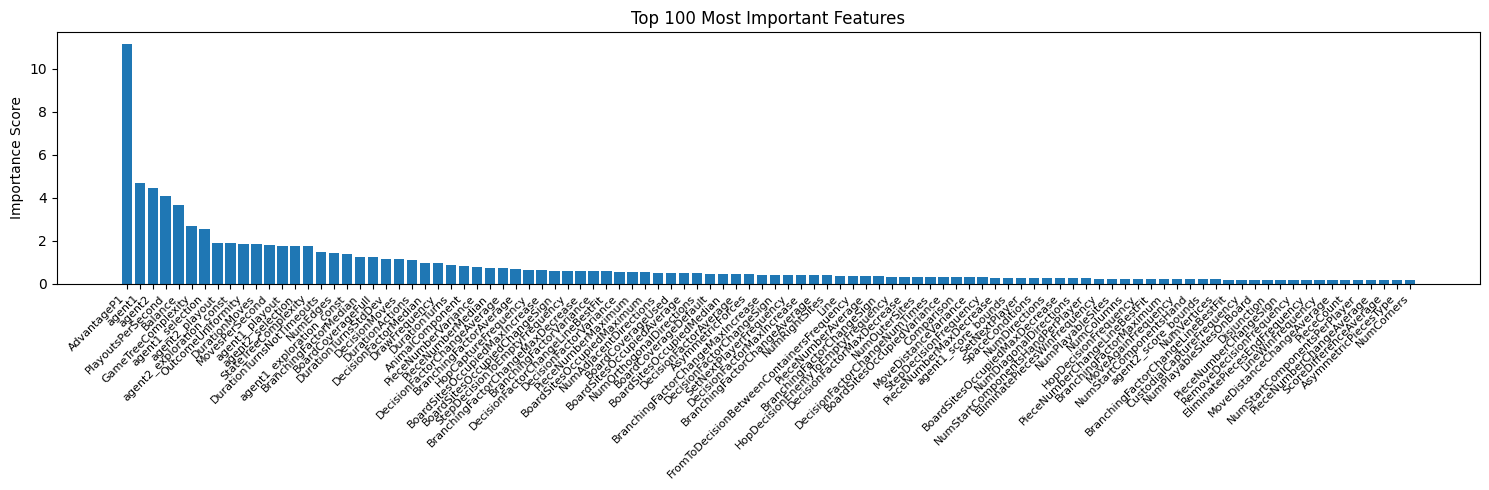

Fold 2 - RMSE: 0.4370922255959416
Fold 3


0:	learn: 0.6019307	test: 0.5983120	best: 0.5983120 (0)	total: 123ms	remaining: 6m 9s


50:	learn: 0.3880711	test: 0.4657229	best: 0.4654702 (49)	total: 6.26s	remaining: 6m 2s


100:	learn: 0.3514076	test: 0.4474566	best: 0.4474566 (100)	total: 12.8s	remaining: 6m 6s


150:	learn: 0.3297371	test: 0.4396884	best: 0.4396884 (150)	total: 19.3s	remaining: 6m 4s


200:	learn: 0.3154119	test: 0.4366173	best: 0.4366173 (200)	total: 26s	remaining: 6m 2s


250:	learn: 0.3037909	test: 0.4344570	best: 0.4343686 (247)	total: 32.7s	remaining: 5m 57s


300:	learn: 0.2944527	test: 0.4324799	best: 0.4324643 (299)	total: 39.3s	remaining: 5m 52s


350:	learn: 0.2864799	test: 0.4311518	best: 0.4311518 (350)	total: 45.9s	remaining: 5m 46s


400:	learn: 0.2802463	test: 0.4304369	best: 0.4304021 (398)	total: 52.7s	remaining: 5m 41s


450:	learn: 0.2739322	test: 0.4296513	best: 0.4295979 (447)	total: 59.4s	remaining: 5m 35s


500:	learn: 0.2683232	test: 0.4291610	best: 0.4290753 (491)	total: 1m 6s	remaining: 5m 29s


550:	learn: 0.2631432	test: 0.4284116	best: 0.4283998 (547)	total: 1m 12s	remaining: 5m 23s


600:	learn: 0.2586832	test: 0.4278123	best: 0.4277888 (599)	total: 1m 19s	remaining: 5m 17s


650:	learn: 0.2543149	test: 0.4272788	best: 0.4272380 (649)	total: 1m 26s	remaining: 5m 10s


700:	learn: 0.2502991	test: 0.4269166	best: 0.4269118 (697)	total: 1m 32s	remaining: 5m 4s


750:	learn: 0.2467634	test: 0.4268842	best: 0.4268349 (734)	total: 1m 39s	remaining: 4m 58s


800:	learn: 0.2432663	test: 0.4264415	best: 0.4264386 (797)	total: 1m 46s	remaining: 4m 51s


850:	learn: 0.2401460	test: 0.4262475	best: 0.4262402 (834)	total: 1m 52s	remaining: 4m 45s


900:	learn: 0.2374285	test: 0.4259552	best: 0.4259481 (882)	total: 1m 59s	remaining: 4m 38s


950:	learn: 0.2344906	test: 0.4257595	best: 0.4257416 (940)	total: 2m 6s	remaining: 4m 32s


1000:	learn: 0.2313091	test: 0.4255332	best: 0.4255142 (996)	total: 2m 12s	remaining: 4m 25s


1050:	learn: 0.2286351	test: 0.4256641	best: 0.4255142 (996)	total: 2m 19s	remaining: 4m 18s


1100:	learn: 0.2260490	test: 0.4254000	best: 0.4253985 (1098)	total: 2m 26s	remaining: 4m 12s


1150:	learn: 0.2237445	test: 0.4252327	best: 0.4252118 (1139)	total: 2m 33s	remaining: 4m 5s


1200:	learn: 0.2213769	test: 0.4250535	best: 0.4250448 (1194)	total: 2m 39s	remaining: 3m 59s


1250:	learn: 0.2190898	test: 0.4250483	best: 0.4250448 (1194)	total: 2m 46s	remaining: 3m 52s


1300:	learn: 0.2169596	test: 0.4250149	best: 0.4250149 (1300)	total: 2m 53s	remaining: 3m 46s


1350:	learn: 0.2147582	test: 0.4247718	best: 0.4247713 (1348)	total: 2m 59s	remaining: 3m 39s


1400:	learn: 0.2128319	test: 0.4245940	best: 0.4245758 (1393)	total: 3m 6s	remaining: 3m 33s


1450:	learn: 0.2108732	test: 0.4245979	best: 0.4245535 (1444)	total: 3m 13s	remaining: 3m 26s


1500:	learn: 0.2087196	test: 0.4245390	best: 0.4245146 (1494)	total: 3m 19s	remaining: 3m 19s


1550:	learn: 0.2067673	test: 0.4245313	best: 0.4245093 (1544)	total: 3m 26s	remaining: 3m 12s


1600:	learn: 0.2048701	test: 0.4243868	best: 0.4243868 (1600)	total: 3m 33s	remaining: 3m 6s


1650:	learn: 0.2030387	test: 0.4244055	best: 0.4243575 (1643)	total: 3m 40s	remaining: 3m


1700:	learn: 0.2012983	test: 0.4243652	best: 0.4243480 (1690)	total: 3m 46s	remaining: 2m 53s


1750:	learn: 0.1995258	test: 0.4242553	best: 0.4242553 (1750)	total: 3m 53s	remaining: 2m 46s


1800:	learn: 0.1977360	test: 0.4242059	best: 0.4241867 (1782)	total: 4m	remaining: 2m 39s


1850:	learn: 0.1960157	test: 0.4241117	best: 0.4241117 (1850)	total: 4m 6s	remaining: 2m 33s


1900:	learn: 0.1942597	test: 0.4240080	best: 0.4240026 (1888)	total: 4m 13s	remaining: 2m 26s


1950:	learn: 0.1926588	test: 0.4241093	best: 0.4240026 (1888)	total: 4m 20s	remaining: 2m 19s


2000:	learn: 0.1909192	test: 0.4240257	best: 0.4240026 (1888)	total: 4m 26s	remaining: 2m 13s


2050:	learn: 0.1893637	test: 0.4239443	best: 0.4239443 (2050)	total: 4m 33s	remaining: 2m 6s


2100:	learn: 0.1878381	test: 0.4239055	best: 0.4238750 (2099)	total: 4m 40s	remaining: 1m 59s


2150:	learn: 0.1862916	test: 0.4238012	best: 0.4238012 (2150)	total: 4m 46s	remaining: 1m 53s


2200:	learn: 0.1848097	test: 0.4237521	best: 0.4237308 (2167)	total: 4m 53s	remaining: 1m 46s


2250:	learn: 0.1831903	test: 0.4237181	best: 0.4237038 (2246)	total: 5m	remaining: 1m 39s


2300:	learn: 0.1818593	test: 0.4236507	best: 0.4236383 (2270)	total: 5m 6s	remaining: 1m 33s


2350:	learn: 0.1802908	test: 0.4236336	best: 0.4235863 (2332)	total: 5m 13s	remaining: 1m 26s


2400:	learn: 0.1787511	test: 0.4236066	best: 0.4235863 (2332)	total: 5m 20s	remaining: 1m 19s


2450:	learn: 0.1774367	test: 0.4236814	best: 0.4235863 (2332)	total: 5m 26s	remaining: 1m 13s


2500:	learn: 0.1760916	test: 0.4236845	best: 0.4235863 (2332)	total: 5m 33s	remaining: 1m 6s


2550:	learn: 0.1746271	test: 0.4237125	best: 0.4235863 (2332)	total: 5m 40s	remaining: 59.9s


2600:	learn: 0.1732248	test: 0.4236458	best: 0.4235863 (2332)	total: 5m 47s	remaining: 53.3s


2650:	learn: 0.1720466	test: 0.4236493	best: 0.4235863 (2332)	total: 5m 53s	remaining: 46.6s


2700:	learn: 0.1708927	test: 0.4236294	best: 0.4235863 (2332)	total: 6m	remaining: 39.9s


2750:	learn: 0.1697109	test: 0.4235264	best: 0.4235264 (2750)	total: 6m 7s	remaining: 33.3s


2800:	learn: 0.1685430	test: 0.4234497	best: 0.4234445 (2798)	total: 6m 14s	remaining: 26.6s


2850:	learn: 0.1673956	test: 0.4234443	best: 0.4234211 (2833)	total: 6m 20s	remaining: 19.9s


2900:	learn: 0.1662526	test: 0.4234386	best: 0.4234211 (2833)	total: 6m 28s	remaining: 13.2s


2950:	learn: 0.1651498	test: 0.4234243	best: 0.4234043 (2934)	total: 6m 34s	remaining: 6.55s


2999:	learn: 0.1639845	test: 0.4233860	best: 0.4233570 (2988)	total: 6m 41s	remaining: 0us

bestTest = 0.4233570312
bestIteration = 2988

Shrink model to first 2989 iterations.


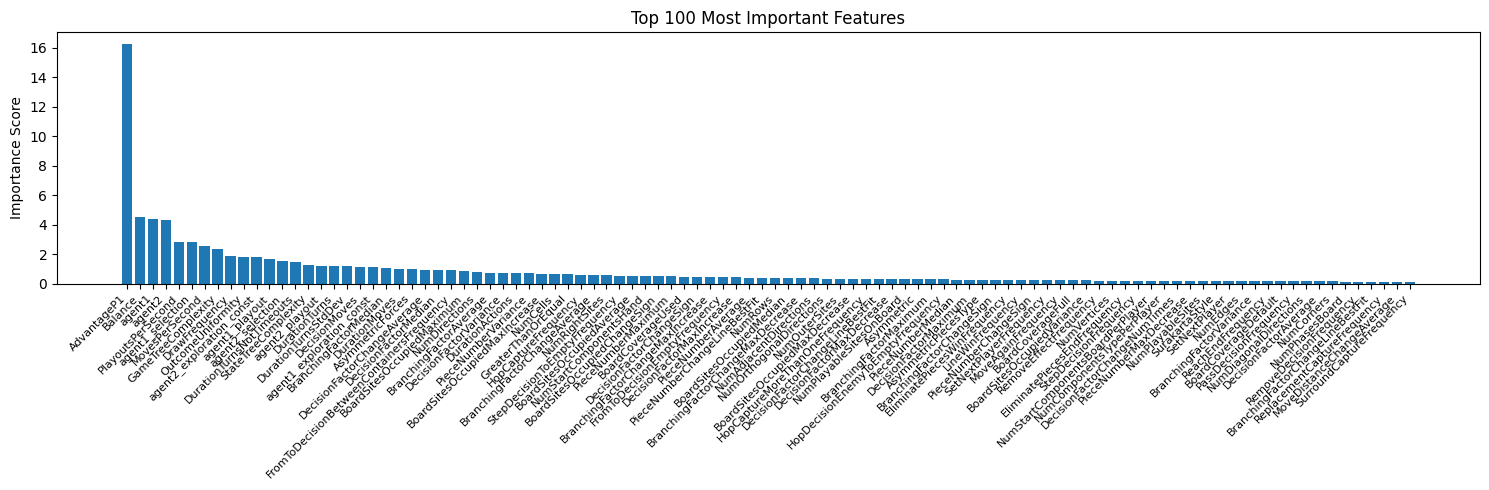

Fold 3 - RMSE: 0.42279010371315273
Fold 4


0:	learn: 0.6048408	test: 0.5901843	best: 0.5901843 (0)	total: 117ms	remaining: 5m 52s


50:	learn: 0.3896942	test: 0.4807267	best: 0.4807117 (49)	total: 6.14s	remaining: 5m 55s


100:	learn: 0.3514850	test: 0.4621864	best: 0.4621864 (100)	total: 12.6s	remaining: 6m 1s


150:	learn: 0.3289541	test: 0.4541189	best: 0.4541189 (150)	total: 18.9s	remaining: 5m 56s


200:	learn: 0.3119841	test: 0.4483169	best: 0.4483169 (200)	total: 25.3s	remaining: 5m 52s


250:	learn: 0.2983610	test: 0.4448488	best: 0.4448227 (249)	total: 31.6s	remaining: 5m 45s


300:	learn: 0.2879306	test: 0.4427379	best: 0.4427379 (300)	total: 37.9s	remaining: 5m 39s


350:	learn: 0.2798927	test: 0.4408826	best: 0.4408826 (350)	total: 44.3s	remaining: 5m 34s


400:	learn: 0.2726166	test: 0.4400669	best: 0.4399262 (394)	total: 50.8s	remaining: 5m 29s


450:	learn: 0.2661973	test: 0.4390131	best: 0.4390080 (449)	total: 57.2s	remaining: 5m 23s


500:	learn: 0.2605459	test: 0.4381062	best: 0.4380980 (499)	total: 1m 3s	remaining: 5m 18s


550:	learn: 0.2558522	test: 0.4375158	best: 0.4375158 (550)	total: 1m 10s	remaining: 5m 13s


600:	learn: 0.2516492	test: 0.4369781	best: 0.4369352 (590)	total: 1m 17s	remaining: 5m 8s


650:	learn: 0.2478629	test: 0.4366703	best: 0.4366703 (650)	total: 1m 23s	remaining: 5m 2s


700:	learn: 0.2437710	test: 0.4362156	best: 0.4362156 (700)	total: 1m 30s	remaining: 4m 56s


750:	learn: 0.2397082	test: 0.4357537	best: 0.4357397 (748)	total: 1m 36s	remaining: 4m 49s


800:	learn: 0.2365402	test: 0.4353427	best: 0.4353427 (800)	total: 1m 43s	remaining: 4m 44s


850:	learn: 0.2335121	test: 0.4349656	best: 0.4349612 (849)	total: 1m 50s	remaining: 4m 38s


900:	learn: 0.2306511	test: 0.4347677	best: 0.4347467 (898)	total: 1m 56s	remaining: 4m 31s


950:	learn: 0.2281746	test: 0.4344956	best: 0.4344956 (950)	total: 2m 3s	remaining: 4m 26s


1000:	learn: 0.2251563	test: 0.4342222	best: 0.4342222 (1000)	total: 2m 10s	remaining: 4m 20s


1050:	learn: 0.2226055	test: 0.4340881	best: 0.4340756 (1033)	total: 2m 16s	remaining: 4m 13s


1100:	learn: 0.2200989	test: 0.4339542	best: 0.4339451 (1095)	total: 2m 23s	remaining: 4m 6s


1150:	learn: 0.2177674	test: 0.4339611	best: 0.4339329 (1121)	total: 2m 29s	remaining: 4m


1200:	learn: 0.2157099	test: 0.4337711	best: 0.4337711 (1200)	total: 2m 36s	remaining: 3m 53s


1250:	learn: 0.2136059	test: 0.4337704	best: 0.4336929 (1229)	total: 2m 42s	remaining: 3m 47s


1300:	learn: 0.2114345	test: 0.4337274	best: 0.4336929 (1229)	total: 2m 49s	remaining: 3m 41s


1350:	learn: 0.2095033	test: 0.4336380	best: 0.4336004 (1343)	total: 2m 55s	remaining: 3m 34s


1400:	learn: 0.2077542	test: 0.4336429	best: 0.4335878 (1375)	total: 3m 2s	remaining: 3m 28s


1450:	learn: 0.2059564	test: 0.4336534	best: 0.4335878 (1375)	total: 3m 9s	remaining: 3m 21s


1500:	learn: 0.2038919	test: 0.4334775	best: 0.4334748 (1499)	total: 3m 15s	remaining: 3m 15s


1550:	learn: 0.2019857	test: 0.4333451	best: 0.4333092 (1533)	total: 3m 22s	remaining: 3m 8s


1600:	learn: 0.2001300	test: 0.4333224	best: 0.4333084 (1586)	total: 3m 28s	remaining: 3m 2s


1650:	learn: 0.1983028	test: 0.4333549	best: 0.4332820 (1611)	total: 3m 35s	remaining: 2m 55s


1700:	learn: 0.1967003	test: 0.4333050	best: 0.4332820 (1611)	total: 3m 41s	remaining: 2m 49s


1750:	learn: 0.1948246	test: 0.4333005	best: 0.4332703 (1713)	total: 3m 48s	remaining: 2m 42s


1800:	learn: 0.1931862	test: 0.4332264	best: 0.4332243 (1797)	total: 3m 54s	remaining: 2m 36s


1850:	learn: 0.1917274	test: 0.4331540	best: 0.4330985 (1848)	total: 4m 1s	remaining: 2m 29s


1900:	learn: 0.1903055	test: 0.4331090	best: 0.4330856 (1884)	total: 4m 7s	remaining: 2m 23s


1950:	learn: 0.1887922	test: 0.4330766	best: 0.4330750 (1948)	total: 4m 14s	remaining: 2m 16s


2000:	learn: 0.1872744	test: 0.4329935	best: 0.4329935 (2000)	total: 4m 20s	remaining: 2m 10s


2050:	learn: 0.1855979	test: 0.4329016	best: 0.4328795 (2043)	total: 4m 27s	remaining: 2m 3s


2100:	learn: 0.1842640	test: 0.4329167	best: 0.4328795 (2043)	total: 4m 33s	remaining: 1m 57s


2150:	learn: 0.1827260	test: 0.4329922	best: 0.4328795 (2043)	total: 4m 40s	remaining: 1m 50s


2200:	learn: 0.1812660	test: 0.4328497	best: 0.4328497 (2200)	total: 4m 46s	remaining: 1m 44s


2250:	learn: 0.1797079	test: 0.4328217	best: 0.4328023 (2241)	total: 4m 53s	remaining: 1m 37s


2300:	learn: 0.1785925	test: 0.4327708	best: 0.4327686 (2296)	total: 4m 59s	remaining: 1m 31s


2350:	learn: 0.1772825	test: 0.4328282	best: 0.4327686 (2296)	total: 5m 6s	remaining: 1m 24s


2400:	learn: 0.1759694	test: 0.4327826	best: 0.4327686 (2296)	total: 5m 13s	remaining: 1m 18s


2450:	learn: 0.1748009	test: 0.4328429	best: 0.4327686 (2296)	total: 5m 19s	remaining: 1m 11s


2500:	learn: 0.1734890	test: 0.4328040	best: 0.4327686 (2296)	total: 5m 26s	remaining: 1m 5s


2550:	learn: 0.1723058	test: 0.4326363	best: 0.4326329 (2549)	total: 5m 32s	remaining: 58.6s


2600:	learn: 0.1710631	test: 0.4326789	best: 0.4326329 (2549)	total: 5m 39s	remaining: 52.1s


2650:	learn: 0.1699239	test: 0.4326764	best: 0.4326329 (2549)	total: 5m 46s	remaining: 45.6s


2700:	learn: 0.1686342	test: 0.4325976	best: 0.4325948 (2699)	total: 5m 52s	remaining: 39.1s


2750:	learn: 0.1674707	test: 0.4325408	best: 0.4325408 (2750)	total: 5m 59s	remaining: 32.5s


2800:	learn: 0.1663251	test: 0.4324989	best: 0.4324807 (2781)	total: 6m 5s	remaining: 26s


2850:	learn: 0.1651204	test: 0.4324590	best: 0.4324587 (2849)	total: 6m 12s	remaining: 19.5s


2900:	learn: 0.1640032	test: 0.4325113	best: 0.4324298 (2858)	total: 6m 18s	remaining: 12.9s


2950:	learn: 0.1628384	test: 0.4326265	best: 0.4324298 (2858)	total: 6m 25s	remaining: 6.4s


2999:	learn: 0.1616206	test: 0.4325765	best: 0.4324298 (2858)	total: 6m 31s	remaining: 0us

bestTest = 0.4324298207
bestIteration = 2858

Shrink model to first 2859 iterations.


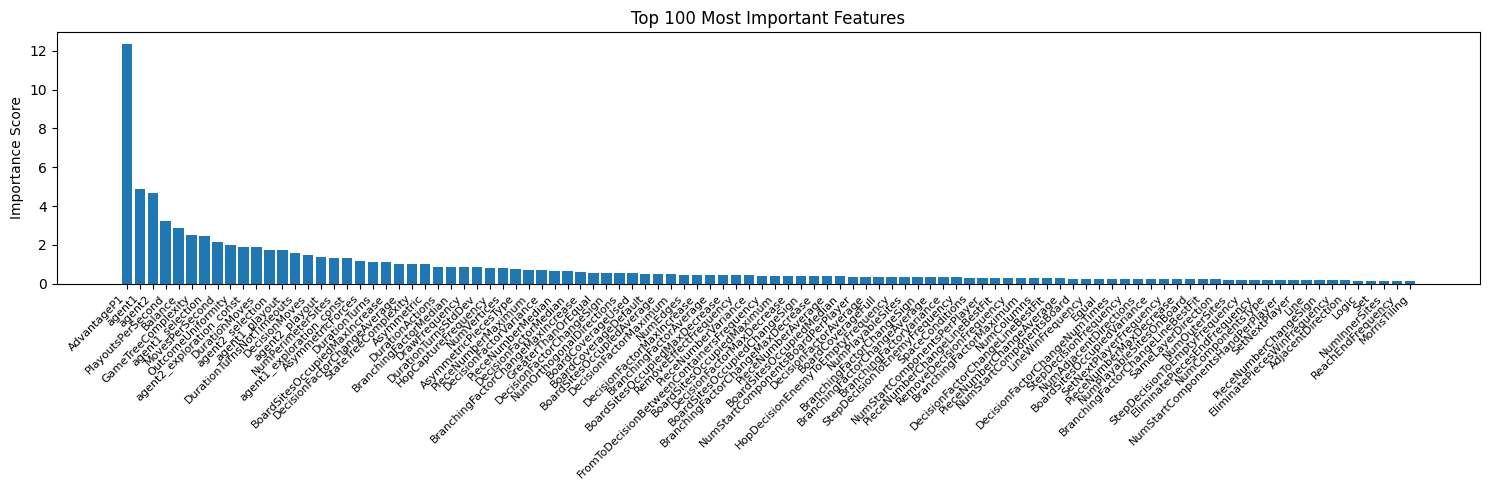

Fold 4 - RMSE: 0.43181181568017174
Fold 5


0:	learn: 0.6164767	test: 0.5407268	best: 0.5407268 (0)	total: 105ms	remaining: 5m 16s


50:	learn: 0.3959692	test: 0.4430259	best: 0.4430259 (50)	total: 6.27s	remaining: 6m 2s


100:	learn: 0.3582178	test: 0.4252781	best: 0.4252781 (100)	total: 12.9s	remaining: 6m 11s


150:	learn: 0.3355035	test: 0.4188753	best: 0.4188726 (149)	total: 19.6s	remaining: 6m 8s


200:	learn: 0.3209721	test: 0.4134704	best: 0.4134514 (199)	total: 26.2s	remaining: 6m 4s


250:	learn: 0.3086200	test: 0.4113320	best: 0.4113320 (250)	total: 32.8s	remaining: 5m 59s


300:	learn: 0.2989702	test: 0.4095807	best: 0.4095628 (299)	total: 39.5s	remaining: 5m 53s


350:	learn: 0.2905627	test: 0.4073638	best: 0.4073638 (350)	total: 46s	remaining: 5m 47s


400:	learn: 0.2834285	test: 0.4059780	best: 0.4059415 (394)	total: 52.7s	remaining: 5m 41s


450:	learn: 0.2774011	test: 0.4050056	best: 0.4050056 (450)	total: 59.4s	remaining: 5m 35s


500:	learn: 0.2722603	test: 0.4042850	best: 0.4042850 (500)	total: 1m 6s	remaining: 5m 30s


550:	learn: 0.2673727	test: 0.4038345	best: 0.4038325 (549)	total: 1m 13s	remaining: 5m 24s


600:	learn: 0.2622404	test: 0.4025539	best: 0.4025539 (600)	total: 1m 19s	remaining: 5m 17s


650:	learn: 0.2577110	test: 0.4025030	best: 0.4025030 (650)	total: 1m 26s	remaining: 5m 11s


700:	learn: 0.2535426	test: 0.4021946	best: 0.4021946 (700)	total: 1m 32s	remaining: 5m 4s


750:	learn: 0.2496045	test: 0.4020148	best: 0.4019680 (738)	total: 1m 39s	remaining: 4m 58s


800:	learn: 0.2466949	test: 0.4015966	best: 0.4015733 (792)	total: 1m 46s	remaining: 4m 52s


850:	learn: 0.2432216	test: 0.4013020	best: 0.4012933 (838)	total: 1m 53s	remaining: 4m 45s


900:	learn: 0.2398369	test: 0.4009926	best: 0.4009926 (900)	total: 1m 59s	remaining: 4m 39s


950:	learn: 0.2370263	test: 0.4008715	best: 0.4007881 (943)	total: 2m 6s	remaining: 4m 32s


1000:	learn: 0.2341847	test: 0.4006588	best: 0.4006588 (1000)	total: 2m 13s	remaining: 4m 26s


1050:	learn: 0.2314686	test: 0.4004275	best: 0.4003651 (1041)	total: 2m 19s	remaining: 4m 19s


1100:	learn: 0.2288895	test: 0.4004363	best: 0.4003651 (1041)	total: 2m 26s	remaining: 4m 12s


1150:	learn: 0.2263227	test: 0.4001888	best: 0.4001710 (1143)	total: 2m 33s	remaining: 4m 6s


1200:	learn: 0.2238218	test: 0.4002231	best: 0.4001334 (1176)	total: 2m 40s	remaining: 4m


1250:	learn: 0.2214738	test: 0.4001174	best: 0.4000735 (1228)	total: 2m 46s	remaining: 3m 53s


1300:	learn: 0.2188978	test: 0.3999449	best: 0.3999431 (1297)	total: 2m 53s	remaining: 3m 46s


1350:	learn: 0.2167993	test: 0.3997417	best: 0.3997417 (1350)	total: 3m	remaining: 3m 40s


1400:	learn: 0.2148702	test: 0.3996893	best: 0.3996893 (1400)	total: 3m 7s	remaining: 3m 33s


1450:	learn: 0.2129038	test: 0.3996458	best: 0.3995749 (1416)	total: 3m 14s	remaining: 3m 27s


1500:	learn: 0.2108191	test: 0.3997785	best: 0.3995749 (1416)	total: 3m 21s	remaining: 3m 20s


1550:	learn: 0.2086120	test: 0.3996985	best: 0.3995749 (1416)	total: 3m 27s	remaining: 3m 14s


1600:	learn: 0.2066815	test: 0.3996171	best: 0.3995749 (1416)	total: 3m 34s	remaining: 3m 7s


1650:	learn: 0.2047269	test: 0.3994959	best: 0.3994959 (1650)	total: 3m 41s	remaining: 3m


1700:	learn: 0.2027640	test: 0.3994577	best: 0.3994006 (1677)	total: 3m 47s	remaining: 2m 54s


1750:	learn: 0.2011164	test: 0.3993859	best: 0.3993839 (1749)	total: 3m 54s	remaining: 2m 47s


1800:	learn: 0.1993208	test: 0.3992180	best: 0.3992103 (1781)	total: 4m 1s	remaining: 2m 40s


1850:	learn: 0.1978332	test: 0.3991497	best: 0.3991350 (1848)	total: 4m 8s	remaining: 2m 34s


1900:	learn: 0.1962737	test: 0.3990956	best: 0.3990616 (1899)	total: 4m 14s	remaining: 2m 27s


1950:	learn: 0.1948116	test: 0.3991102	best: 0.3990581 (1934)	total: 4m 21s	remaining: 2m 20s


2000:	learn: 0.1932235	test: 0.3991085	best: 0.3990581 (1934)	total: 4m 28s	remaining: 2m 14s


2050:	learn: 0.1916120	test: 0.3991269	best: 0.3990581 (1934)	total: 4m 35s	remaining: 2m 7s


2100:	learn: 0.1900286	test: 0.3990952	best: 0.3990581 (1934)	total: 4m 41s	remaining: 2m


2150:	learn: 0.1886366	test: 0.3990562	best: 0.3990557 (2149)	total: 4m 48s	remaining: 1m 53s


2200:	learn: 0.1872763	test: 0.3991165	best: 0.3990557 (2149)	total: 4m 55s	remaining: 1m 47s


2250:	learn: 0.1858063	test: 0.3990802	best: 0.3990557 (2149)	total: 5m 2s	remaining: 1m 40s


2300:	learn: 0.1843254	test: 0.3991002	best: 0.3990534 (2273)	total: 5m 8s	remaining: 1m 33s


2350:	learn: 0.1828992	test: 0.3990450	best: 0.3990363 (2324)	total: 5m 15s	remaining: 1m 27s


2400:	learn: 0.1815633	test: 0.3989930	best: 0.3989895 (2396)	total: 5m 22s	remaining: 1m 20s


2450:	learn: 0.1799793	test: 0.3989932	best: 0.3989465 (2415)	total: 5m 29s	remaining: 1m 13s


2500:	learn: 0.1786207	test: 0.3989002	best: 0.3988730 (2497)	total: 5m 35s	remaining: 1m 6s


2550:	learn: 0.1772086	test: 0.3988384	best: 0.3988384 (2550)	total: 5m 42s	remaining: 1m


2600:	learn: 0.1759965	test: 0.3988425	best: 0.3987961 (2565)	total: 5m 49s	remaining: 53.6s


2650:	learn: 0.1747675	test: 0.3987886	best: 0.3987886 (2650)	total: 5m 55s	remaining: 46.9s


2700:	learn: 0.1736220	test: 0.3988130	best: 0.3987756 (2671)	total: 6m 2s	remaining: 40.2s


2750:	learn: 0.1724622	test: 0.3987996	best: 0.3987668 (2737)	total: 6m 9s	remaining: 33.4s


2800:	learn: 0.1713350	test: 0.3987926	best: 0.3987668 (2737)	total: 6m 16s	remaining: 26.7s


2850:	learn: 0.1702280	test: 0.3988410	best: 0.3987668 (2737)	total: 6m 22s	remaining: 20s


2900:	learn: 0.1690546	test: 0.3987818	best: 0.3987668 (2737)	total: 6m 29s	remaining: 13.3s


2950:	learn: 0.1681053	test: 0.3988108	best: 0.3987668 (2737)	total: 6m 36s	remaining: 6.58s


2999:	learn: 0.1669690	test: 0.3987586	best: 0.3987571 (2998)	total: 6m 42s	remaining: 0us

bestTest = 0.3987571299
bestIteration = 2998

Shrink model to first 2999 iterations.


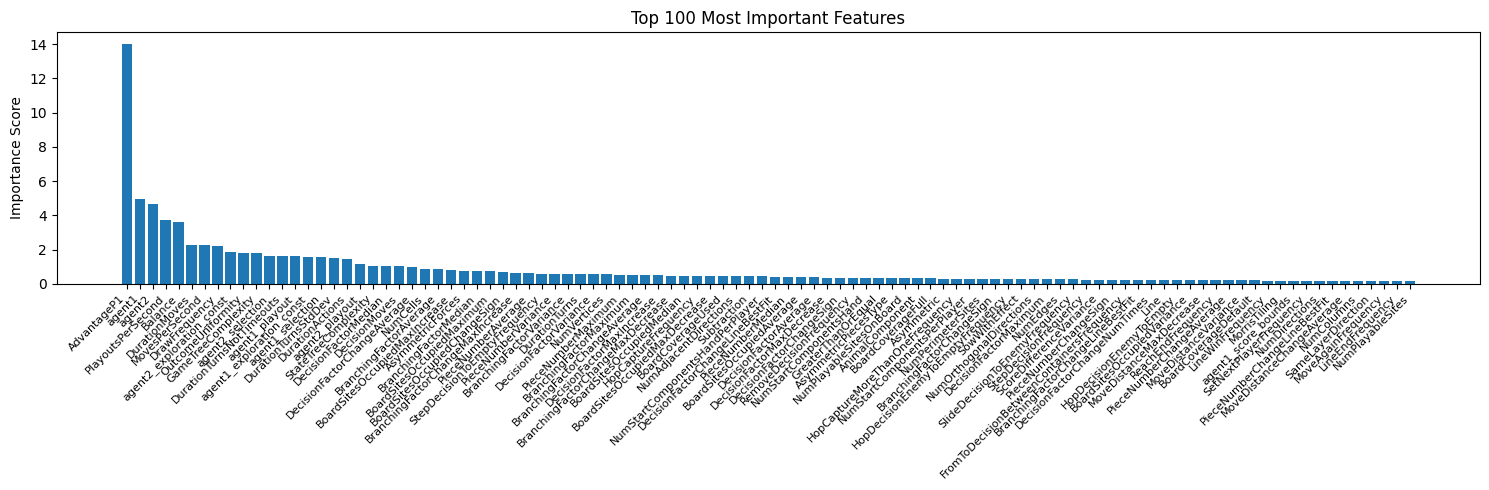

Fold 5 - RMSE: 0.39825344181531525
List of oof scores: [0.41473341825229054, 0.4370922255959416, 0.42279010371315273, 0.43181181568017174, 0.39825344181531525]
Average oof score: 0.4209362010113744


In [9]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
# oof1.to_csv(path_results / 'oof_catboost_cv1.csv', index=False)
# save feature importance
importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

In [10]:
# # call the function
# trained_models3, oof3, oof_scores3 = train_models(
#     df_train, 
#     numerical_cols, 
#     categorical_cols, 
#     text_cols=text_cols,
#     split_list=split3,
# )
# # save oof predictions
# oof3.to_csv(path_results / 'oof_catboost_cv3.csv', index=False)

In [11]:
# trained_models = [*trained_models1, *trained_models2, *trained_models3]
trained_models = trained_models1

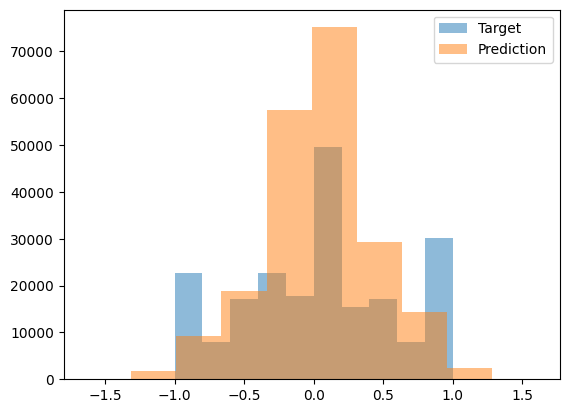

In [12]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [13]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [14]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [15]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

Id,utility_agent1
i64,f64
233234,0.101733
233235,-0.15715
233236,-0.030416


In [16]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [17]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    # 'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}

with open('./catboost_predict.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***